Epoch:0/1000 Error_train:1.1134563667864157 Error_test:1.1095632410221519
Epoch:100/1000 Error_train:0.0257713686901312 Error_test:0.07507194829016638
Epoch:200/1000 Error_train:0.007074415937608537 Error_test:0.1017457931445822
Epoch:300/1000 Error_train:0.0031077543637443358 Error_test:0.125691940107541
Epoch:400/1000 Error_train:0.0017526161555850388 Error_test:0.14637103097085621
Epoch:500/1000 Error_train:0.001150561750957827 Error_test:0.16173208440933645
Epoch:600/1000 Error_train:0.000835757892455128 Error_test:0.1739989614866767
Epoch:700/1000 Error_train:0.0006461061894571544 Error_test:0.1849335194587535
Epoch:800/1000 Error_train:0.000521857456925509 Error_test:0.19415018903943485
Epoch:900/1000 Error_train:0.0004329513447624968 Error_test:0.20180506794081773


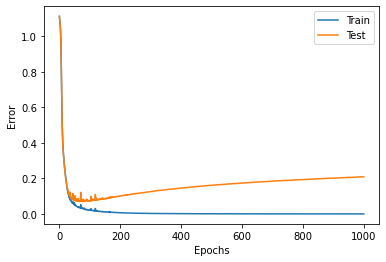

Actuary Train:100.0% Actuary Test:96.0%


In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

#データの読み込み
iris_data = datasets.load_iris()
input_data = iris_data.data
correct = iris_data.target
n_data = len(correct)

#入力の標準化
ave_input = np.average(input_data, axis=0)
std_input = np.std(input_data, axis=0)
input_data = (input_data - ave_input) / std_input

#正解のone hot化
correct_data = np.zeros((n_data, 3))
for i in range(n_data):
    correct_data[i,correct[i]] = 1.0

#訓練データとテストデータに分類
index = np.arange(n_data)
index_train = index[index % 2 == 0]
index_test = index[index % 2 != 0]

input_train = input_data[index_train, :] #訓練入力
correct_train = correct_data[index_train, :] #訓練正解
input_test = input_data[index_test, :] #テスト入力
correct_test = correct_data[index_test, :] #テスト正解

n_train = input_train.shape[0] #訓練データのサンプル数
n_test = input_test.shape[0] #テストデータのサンプル数

#各値設定
n_in = 4
n_mid = 25
n_out = 3

wb_width = 0.1
eta = 0.01
epoch = 1000
batch_size = 8
interval = 100

#各層の継承元(中間層と出力層で共通している部分)
class Baselayer:
    def __init__(self, n_upper, n):
        self.w = wb_width * np.random.randn(n_upper, n)
        self.b = wb_width * np.random.randn(n)

    def update(self, eta):
        self.w -= eta * self.grad_w
        self.b -= eta * self.grad_b

#中間層
class Middlelayer(Baselayer):
    def forward(self, x):
        self.x = x
        self.u = np.dot(x,self.w) + self.b
        self.y = np.where(self.u <= 0, 0, self.u) #ReLU
    def backward(self, grad_y):
        delta = grad_y * np.where(self.u <= 0, 0, 1) #ReLUの微分
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)
        self.grad_x = np.dot(delta, self.w.T)

#出力層
class Outputlayer(Baselayer):
    def forward(self, x):
        self.x = x
        u = np.dot(x, self.w) + self.b
        self.y = np.exp(u)/np.sum(np.exp(u), axis = 1, keepdims = True)
    def backward(self, t):
        delta = self.y - t
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)
        self.grad_x = np.dot(delta, self.w.T)

#各層の初期化
middle_layer_1 = Middlelayer(n_in, n_mid)
middle_layer_2 = Middlelayer(n_mid, n_mid)
output_layer = Outputlayer(n_mid, n_out)

#順伝播
def forward_proragation(x):
    middle_layer_1.forward(x)
    middle_layer_2.forward(middle_layer_1.y)
    output_layer.forward(middle_layer_2.y)

#逆伝播
def backpropagation(t):
    output_layer.backward(t)
    middle_layer_2.backward(output_layer.grad_x)
    middle_layer_1.backward(middle_layer_2.grad_x)

#重みとバイアスの更新
def uppdate_wb():
    middle_layer_1.update(eta)
    middle_layer_2.update(eta)
    output_layer.update(eta)

#交差エントロピーを計算
def get_error(t, batch_size):
    return -np.sum(t*np.log(output_layer.y + 1e-7)) / batch_size
train_error_x = []
train_error_y = []
test_error_x = []
test_error_y = []

#学習と経過の記録
n_batch = n_train // batch_size #1エポック当たりのバッジ数
for i in range(epoch):
    #誤差の計算
    forward_proragation(input_train)
    error_train = get_error(correct_train, n_train)
    forward_proragation(input_test)
    error_test = get_error(correct_test, n_test)

    #誤差の記録
    test_error_x.append(i)
    test_error_y.append(error_test)
    train_error_x.append(i)
    train_error_y.append(error_train)

    #経過の表示
    if i % interval == 0:
        print(f"Epoch:{str(i)}/{str(epoch)}", 
              f"Error_train:{str(error_train)}", 
              f"Error_test:{str(error_test)}")
        
    #学習
    index_random = np.arange(n_train)
    np.random.shuffle(index_random)
    for j in range(n_batch):

        #ミニバッチを取り出す
        mb_index = index_random[j*batch_size : (j+1)*batch_size]
        x = input_train[mb_index, :]
        t = correct_train[mb_index, :]

        #順伝播と逆伝播
        forward_proragation(x)
        backpropagation(t)
        #重みとバイアスの更新
        uppdate_wb()

#誤差の記録をグラフ表示
plt.plot(train_error_x, train_error_y, label="Train")
plt.plot(test_error_x, test_error_y, label="Test")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

#正解率の測定
forward_proragation(input_train)
count_train = np.sum(np.argmax(output_layer.y,axis=1) == np.argmax(correct_train, axis=1))

forward_proragation(input_test)
count_test = np.sum(np.argmax(output_layer.y,axis=1) == np.argmax(correct_test, axis=1))

print(f"Actuary Train:{str(count_train/n_train*100)}%",f"Actuary Test:{str(count_test/n_test*100)}%")

Epoch:0/1000 Error_train:1.0957201711722273 Error_test:1.0950695450119647
Epoch:100/1000 Error_train:0.05004782943866698 Error_test:0.09220402102942159
Epoch:200/1000 Error_train:0.025922529729137035 Error_test:0.08633633754419473
Epoch:300/1000 Error_train:0.016904551790239336 Error_test:0.08596026292645789
Epoch:400/1000 Error_train:0.012165347154648166 Error_test:0.08624591574712887
Epoch:500/1000 Error_train:0.00922711936024601 Error_test:0.08727203324339293
Epoch:600/1000 Error_train:0.007326098606987917 Error_test:0.08913429780494014
Epoch:700/1000 Error_train:0.005977240764057239 Error_test:0.09046994399743707
Epoch:800/1000 Error_train:0.004992966374760596 Error_test:0.09216926639674317
Epoch:900/1000 Error_train:0.004220518897187092 Error_test:0.094075567575705


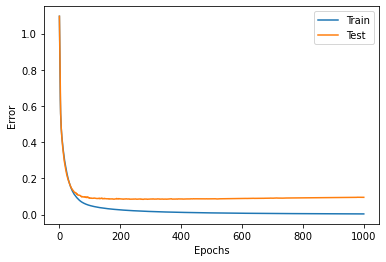

Actuary Train:100.0% Actuary Test:96.0%


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from tqdm import tqdm

#データの読み込み
iris_data = datasets.load_iris()
input_data = iris_data.data
correct = iris_data.target
n_data = len(correct)

#入力の標準化
ave_input = np.average(input_data, axis=0)
std_input = np.std(input_data, axis=0)
input_data = (input_data - ave_input) / std_input

#正解のone hot化
correct_data = np.zeros((n_data, 3))
for i in range(n_data):
    correct_data[i,correct[i]] = 1.0

#訓練データとテストデータに分類
index = np.arange(n_data)
index_train = index[index % 2 == 0]
index_test = index[index % 2 != 0]

input_train = input_data[index_train, :] #訓練入力
correct_train = correct_data[index_train, :] #訓練正解
input_test = input_data[index_test, :] #テスト入力
correct_test = correct_data[index_test, :] #テスト正解

n_train = input_train.shape[0] #訓練データのサンプル数
n_test = input_test.shape[0] #テストデータのサンプル数

#各値設定
n_in = 4
n_mid = 25
n_out = 3

wb_width = 0.1
eta = 0.01
epoch = 1000
batch_size = 8
interval = 100

#各層の継承元(中間層と出力層で共通している部分)
class Baselayer:
    def __init__(self, n_upper, n):
        self.w = wb_width * np.random.randn(n_upper, n)
        self.b = wb_width * np.random.randn(n)

        self.h_w = np.zeros((n_upper, n)) + 1e-8
        self.h_b = np.zeros(n) + 1e-8

    def update(self, eta):
        self.h_w += self.grad_w * self.grad_w
        self.w -= eta / np.sqrt(self.h_w) * self.grad_w

        self.h_b += self.grad_b * self.grad_b
        self.b -= eta / np.sqrt(self.h_b) * self.grad_b

#ドロップアウト
class Dropout:
    def __init__(self, dropout_ratio):
        self.dropout_ratio = dropout_ratio
    
    def forward(self, x, is_train):
        if is_train:
            rand = np.random.randn(*x.shape)
            self.dropout = np.where(rand > self.dropout_ratio, 1, 0)
            self.y = x * self.dropout
        else:
            self.y = (1-self.dropout_ratio)*x

    def bacward(self, grad_y):
        self.grad_x = grad_y * self.dropout       
        

#中間層
class Middlelayer(Baselayer):
    def forward(self, x):
        self.x = x
        self.u = np.dot(x,self.w) + self.b
        self.y = np.where(self.u <= 0, 0, self.u) #ReLU
    def backward(self, grad_y):
        delta = grad_y * np.where(self.u <= 0, 0, 1) #ReLUの微分
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)
        self.grad_x = np.dot(delta, self.w.T)

#出力層
class Outputlayer(Baselayer):
    def forward(self, x):
        self.x = x
        u = np.dot(x, self.w) + self.b
        self.y = np.exp(u)/np.sum(np.exp(u), axis = 1, keepdims = True)
    def backward(self, t):
        delta = self.y - t
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)
        self.grad_x = np.dot(delta, self.w.T)

#各層の初期化
middle_layer_1 = Middlelayer(n_in, n_mid)
dropout_1 = Dropout(0.5)
middle_layer_2 = Middlelayer(n_mid, n_mid)
dropout_2 = Dropout(0.5)
output_layer = Outputlayer(n_mid, n_out)

#順伝播
def forward_proragation(x):
    middle_layer_1.forward(x)
    
    middle_layer_2.forward(middle_layer_1.y)
    
    output_layer.forward(middle_layer_2.y)

#逆伝播
def backpropagation(t):
    output_layer.backward(t)
    
    middle_layer_2.backward(output_layer.grad_x)
   
    middle_layer_1.backward(middle_layer_2.grad_x)

#重みとバイアスの更新
def uppdate_wb():
    middle_layer_1.update(eta)
    middle_layer_2.update(eta)
    output_layer.update(eta)

#交差エントロピーを計算
def get_error(t, batch_size):
    return -np.sum(t*np.log(output_layer.y + 1e-7)) / batch_size
train_error_x = []
train_error_y = []
test_error_x = []
test_error_y = []

#学習と経過の記録
n_batch = n_train // batch_size #1エポック当たりのバッジ数
for i in range(epoch):
    #誤差の計算
    forward_proragation(input_train)
    error_train = get_error(correct_train, n_train)
    forward_proragation(input_test)
    error_test = get_error(correct_test, n_test)

    #誤差の記録
    test_error_x.append(i)
    test_error_y.append(error_test)
    train_error_x.append(i)
    train_error_y.append(error_train)

    #経過の表示
    if i % interval == 0:
        print(f"Epoch:{str(i)}/{str(epoch)}", 
              f"Error_train:{str(error_train)}", 
              f"Error_test:{str(error_test)}")
        
    #学習
    index_random = np.arange(n_train)
    np.random.shuffle(index_random)
    for j in range(n_batch):

        #ミニバッチを取り出す
        mb_index = index_random[j*batch_size : (j+1)*batch_size]
        x = input_train[mb_index, :]
        t = correct_train[mb_index, :]

        #順伝播と逆伝播
        forward_proragation(x)
        backpropagation(t)
        #重みとバイアスの更新
        uppdate_wb()

#誤差の記録をグラフ表示
plt.plot(train_error_x, train_error_y, label="Train")
plt.plot(test_error_x, test_error_y, label="Test")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

#正解率の測定
forward_proragation(input_train)
count_train = np.sum(np.argmax(output_layer.y,axis=1) == np.argmax(correct_train, axis=1))

forward_proragation(input_test)
count_test = np.sum(np.argmax(output_layer.y,axis=1) == np.argmax(correct_test, axis=1))

tqdm(print(f"Actuary Train:{str(count_train/n_train*100)}%",f"Actuary Test:{str(count_test/n_test*100)}%"))

In [ ]:
def forward_proragation(x):
    middle_layer_1.forward(x)
    
    middle_layer_2.forward(middle_layer_1.y)
    
    output_layer.forward(middle_layer_2.y)

#逆伝播
def backpropagation(t):
    output_layer.backward(t)
    
    middle_layer_2.backward(output_layer.grad_x)
   
    middle_layer_1.backward(middle_layer_2.grad_x)


    def forward_proragation(x, is_train):
    middle_layer_1.forward(x)
    dropout_1.forward(middle_layer_1.y, is_train)
    middle_layer_2.forward(dropout_1.y)
    dropout_2.forward(middle_layer_2.y, is_train)
    output_layer.forward(dropout_2.y)

#逆伝播
def backpropagation(t):
    output_layer.backward(t)
    dropout_2.bacward(output_layer.grad_x)
    middle_layer_2.backward(dropout_2.grad_x)
    dropout_1.backward(middle_layer_2.grad_x)
    middle_layer_1.backward(dropout_1.grad_x)